In [43]:
# Image classification CA1
# Basic imports
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

# Deep Learning Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Utilities for data processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset
from tensorflow.keras.datasets import cifar10, cifar100

In [44]:
def load_cifar10_filtered(selected_classes, validation_split=0.1):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    train_mask = np.isin(y_train, selected_classes).reshape(-1)
    test_mask = np.isin(y_test, selected_classes).reshape(-1)

    x_train_filtered = x_train[train_mask]
    y_train_filtered = y_train[train_mask]

    x_test_filtered = x_test[test_mask]
    y_test_filtered = y_test[test_mask]

    x_train_filtered, x_valid_filtered, y_train_filtered, y_valid_filtered = train_test_split(
        x_train_filtered, y_train_filtered, test_size=validation_split, random_state=42
    )

    return (x_train_filtered, y_train_filtered), (x_valid_filtered, y_valid_filtered), (x_test_filtered, y_test_filtered)

In [45]:
def load_cifar100_filtered(selected_classes, validation_split=0.1, cifar10_classes=10):
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    tree_label = 101
    y_train_filtered = np.where(np.isin(y_train, [47,52,56,59,96]), tree_label, y_train)
    y_test_filtered = np.where(np.isin(y_test, [47,52,56,59,96]), tree_label, y_test)

    y_train_filtered += cifar10_classes
    y_test_filtered += cifar10_classes

    train_mask = np.isin(y_train_filtered, [tree_label] + selected_classes).reshape(-1)
    test_mask = np.isin(y_test_filtered, [tree_label] + selected_classes).reshape(-1)

    x_train_filtered = x_train[train_mask]
    y_train_filtered = y_train_filtered[train_mask]

    x_test_filtered = x_test[test_mask]
    y_test_filtered = y_test_filtered[test_mask]

    x_train_filtered, x_valid_filtered, y_train_filtered, y_valid_filtered = train_test_split(
        x_train_filtered, y_train_filtered, test_size=validation_split, random_state=42
    )

    return (x_train_filtered, y_train_filtered), (x_valid_filtered, y_valid_filtered), (x_test_filtered, y_test_filtered)

In [46]:
def combine_cifar_datasets(x_train_cifar10, y_train_cifar10, x_valid_cifar10, y_valid_cifar10,
                           x_test_cifar10, y_test_cifar10, x_train_cifar100, y_train_cifar100,
                           x_valid_cifar100, y_valid_cifar100, x_test_cifar100, y_test_cifar100):

    x_train_combined = np.vstack([x_train_cifar10, x_train_cifar100])
    y_train_combined = np.concatenate([y_train_cifar10.flatten(), y_train_cifar100.flatten()])

    x_valid_combined = np.vstack([x_valid_cifar10, x_valid_cifar100])
    y_valid_combined = np.concatenate([y_valid_cifar10.flatten(), y_valid_cifar100.flatten()])

    x_test_combined = np.vstack([x_test_cifar10, x_test_cifar100])
    y_test_combined = np.concatenate([y_test_cifar10.flatten(), y_test_cifar100.flatten()])

    return (x_train_combined, y_train_combined), (x_valid_combined, y_valid_combined), (x_test_combined, y_test_combined)

In [47]:
def print_dataset_shapes(name, x_train, y_train, x_valid, y_valid, x_test, y_test):
    print(f"{name} shapes:")
    print("Train data:", x_train.shape)
    print("Train labels:", y_train.shape)
    print("Validation data:", x_valid.shape)
    print("Validation labels:", y_valid.shape)
    print("Test data:", x_test.shape)
    print("Test labels:", y_test.shape)

In [48]:
def assert_dataset_properties(name, x, y, expected_shape, expected_channels=3):
    assert x.shape[0] == y.shape[0], f"The number of {name} images is different from the number of labels"
    assert x.shape[1:] == expected_shape, f"The {name} images are not {expected_shape}"

    if len(expected_shape) == 3 and x.shape[-1] != expected_channels:
        raise ValueError(f"The {name} images do not have {expected_channels} channels")

In [49]:
def load_and_explore_datasets(classes_cifar10, classes_cifar100):
    (x_train_cifar10, y_train_cifar10), (x_valid_cifar10, y_valid_cifar10), (x_test_cifar10, y_test_cifar10) = \
        load_cifar10_filtered(classes_cifar10)
    print_dataset_shapes("CIFAR-10", x_train_cifar10, y_train_cifar10, x_valid_cifar10, y_valid_cifar10, x_test_cifar10, y_test_cifar10)
    assert_dataset_properties("CIFAR-10 Train", x_train_cifar10, y_train_cifar10, expected_shape=(32, 32, 3))
    assert_dataset_properties("CIFAR-10 Validation", x_valid_cifar10, y_valid_cifar10, expected_shape=(32, 32, 3))
    assert_dataset_properties("CIFAR-10 Test", x_test_cifar10, y_test_cifar10, expected_shape=(32, 32, 3))

    (x_train_cifar100, y_train_cifar100), (x_valid_cifar100, y_valid_cifar100), (x_test_cifar100, y_test_cifar100) = \
        load_cifar100_filtered(classes_cifar100)
    print_dataset_shapes("CIFAR-100", x_train_cifar100, y_train_cifar100, x_valid_cifar100, y_valid_cifar100, x_test_cifar100, y_test_cifar100)
    assert_dataset_properties("CIFAR-100 Train", x_train_cifar100, y_train_cifar100, expected_shape=(32, 32, 3))
    assert_dataset_properties("CIFAR-100 Validation", x_valid_cifar100, y_valid_cifar100, expected_shape=(32, 32, 3))
    assert_dataset_properties("CIFAR-100 Test", x_test_cifar100, y_test_cifar100, expected_shape=(32, 32, 3))

    (x_train, y_train), (x_valid, y_valid), (x_test, y_test) = \
        combine_cifar_datasets(x_train_cifar10, y_train_cifar10, x_valid_cifar10, y_valid_cifar10,
                               x_test_cifar10, y_test_cifar10, x_train_cifar100, y_train_cifar100,
                               x_valid_cifar100, y_valid_cifar100, x_test_cifar100, y_test_cifar100)
    print_dataset_shapes("Combined CIFAR datasets", x_train, y_train, x_valid, y_valid, x_test, y_test)
    assert_dataset_properties("Combined Train", x_train, y_train, expected_shape=(32, 32, 3))
    assert_dataset_properties("Combined Validation", x_valid, y_valid, expected_shape=(32, 32, 3))
    assert_dataset_properties("Combined Test", x_test, y_test, expected_shape=(32, 32, 3))

    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test)

In [50]:
def plot_images(X, y, class_labels, class_names):
    cols = 5
    num_classes = len(class_labels)

    fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
    fig.tight_layout()
    for i in range(cols):
        for j, class_label in enumerate(class_labels):
            x_selected = X[np.where(y == class_label)[0]]

            if len(x_selected) > 0:
                axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :])
                axs[j][i].axis("off")

                if i == 2 and j < len(class_names):
                    axs[j][i].set_title(f"{j} - {class_names[j]}")
    plt.show()

In [51]:
def plot_distribution(y, class_labels):
    num_of_samples = []
    for class_label in class_labels:
        x_selected = y[y == class_label]
        num_of_samples.append(len(x_selected))

    plt.figure(figsize=(12, 4))
    plt.bar(range(0, len(class_labels)), num_of_samples)
    plt.title("Distribution of the training set")
    plt.xlabel("Class number")
    plt.ylabel("Number of images")
    plt.show()

In [52]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.equalizeHist(img)
        img = img / 255.0
        img = cv2.resize(img, (32, 32))
        processed_images.append(img)
    return np.array(processed_images)

In [53]:
def preprocess_data(x_train, y_train, x_valid, y_valid, x_test, y_test):
    x_train = preprocess_images(x_train)
    x_valid = preprocess_images(x_valid)
    x_test = preprocess_images(x_test)
    return x_train, y_train, x_valid, y_valid, x_test, y_test

In [54]:
def plot_preprocessed_data(X_train, y_train):
    X_train = X_train.reshape(X_train.shape + (1,))

    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
    datagen.fit(X_train)
    batches = datagen.flow(X_train, y_train, batch_size=20)
    X_batch, y_batch = next(batches)

    fig, axs = plt.subplots(1, 20, figsize=(20, 5))
    fig.tight_layout()
    for i in range(20):
        axs[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
        axs[i].axis('off')
    plt.show()

In [55]:
def remove_samples(X, y, classes_to_remove, samples_to_remove):
    indices_to_keep = []
    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        np.random.shuffle(class_indices)
        if class_label in classes_to_remove:
            class_indices = class_indices[:samples_to_remove]
        indices_to_keep.extend(class_indices)
    np.random.shuffle(indices_to_keep)

    filtered_X = X[indices_to_keep]
    filtered_y = y[indices_to_keep]
    return filtered_X, filtered_y

In [56]:
classes_cifar10 = [1, 2, 3, 4, 5, 7, 9]
classes_cifar100 = [12, 18, 21, 23, 29, 44, 45, 51, 56, 58, 68, 75, 90, 99, 100, 108, 111]
class_names_cifar10 = ['automobile', 'bird', 'cat', 'deer', 'dog', 'horse', 'truck']
class_names_cifar100 = ['baby', 'bicycle', 'boy', 'bus', 'cattle', 'fox', 'girl', 'lawn mower', 'man', 'motorcycle', 'pickup truck', 'rabbit', 'squirrel', 'tractor', 'train', 'woman', 'trees']
combined_classes = classes_cifar10 + classes_cifar100
combined_classes_name = class_names_cifar10 + class_names_cifar100

In [57]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_and_explore_datasets(classes_cifar10, classes_cifar100)

CIFAR-10 shapes:
Train data: (31500, 32, 32, 3)
Train labels: (31500, 1)
Validation data: (3500, 32, 32, 3)
Validation labels: (3500, 1)
Test data: (7000, 32, 32, 3)
Test labels: (7000, 1)
CIFAR-100 shapes:
Train data: (9900, 32, 32, 3)
Train labels: (9900, 1)
Validation data: (1100, 32, 32, 3)
Validation labels: (1100, 1)
Test data: (2200, 32, 32, 3)
Test labels: (2200, 1)
Combined CIFAR datasets shapes:
Train data: (41400, 32, 32, 3)
Train labels: (41400,)
Validation data: (4600, 32, 32, 3)
Validation labels: (4600,)
Test data: (9200, 32, 32, 3)
Test labels: (9200,)


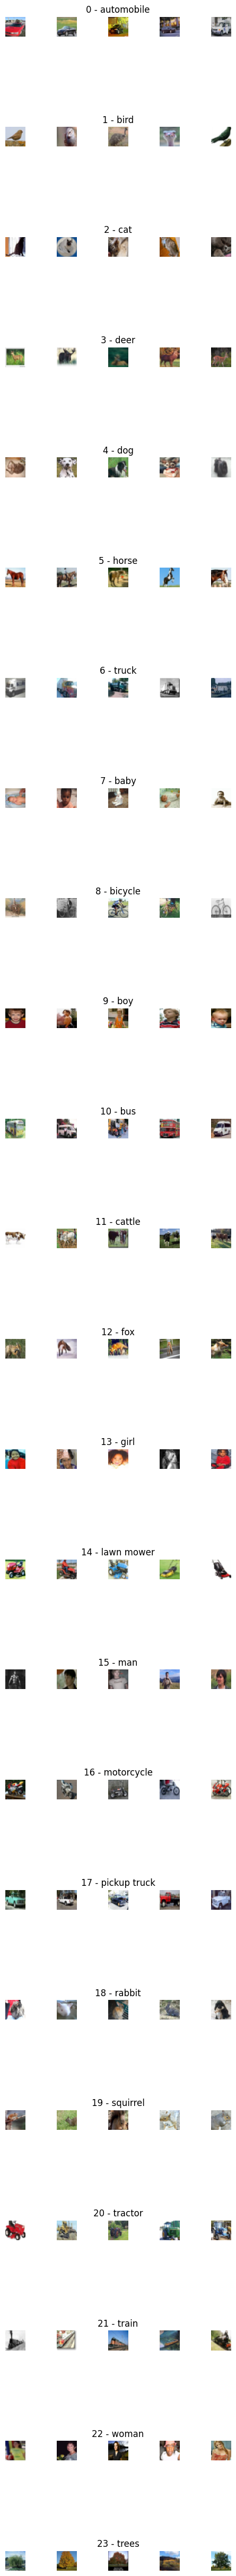

In [58]:
plot_images(x_train, y_train, combined_classes, combined_classes_name)

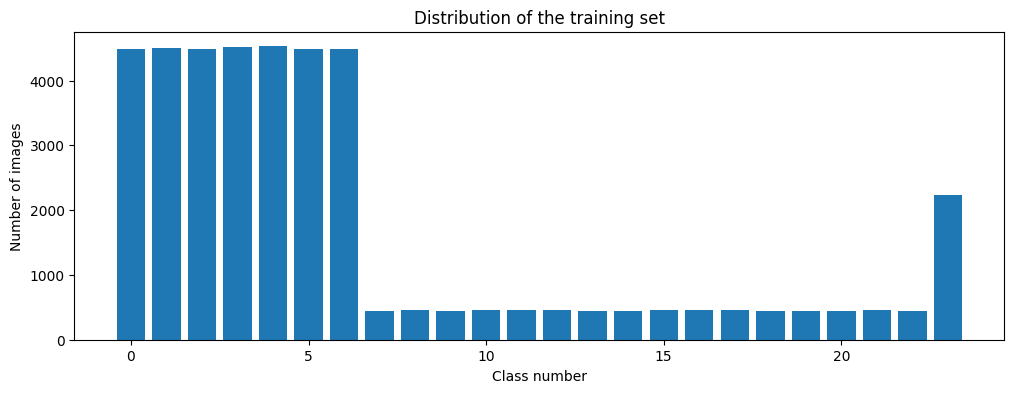

In [59]:
plot_distribution(y_train, combined_classes)

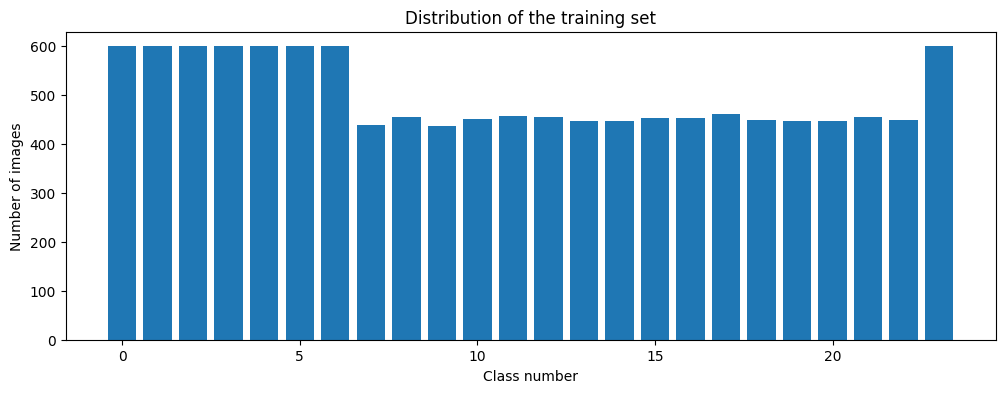

In [60]:
x_train, y_train = remove_samples(x_train, y_train, [1,2,3,4,5,7,9,111], 600)
plot_distribution(y_train, combined_classes)

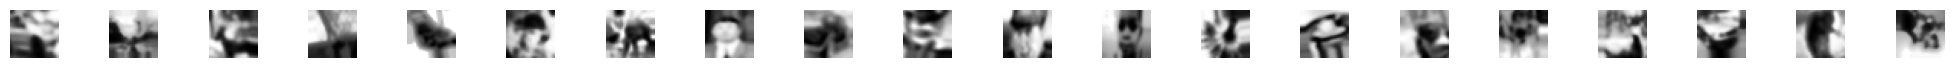

In [61]:
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_data(x_train, y_train, x_valid, y_valid, x_test, y_test)
plot_preprocessed_data(x_train, y_train)